In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt 
import pickle
import os
import numpy as np
import hopsworks

/Users/jp/Documents/GitHub/scalable_ml/id2223/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Read all data

In [3]:
obs = pd.read_csv('../data/beetle/artportalen/artportalen_final.csv')
obs["month"] = pd.to_datetime(obs['date']).dt.to_period("M").dt.to_timestamp()
print(f"Datapoints (observations): {len(obs)}")
obs.head(5)

Datapoints (observations): 5022


,row_id,lat,lon,date,kommun,lan,quantity,pressence,month
0,0,58.788614,15.821428,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01
1,1,58.788632,15.817157,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01
2,2,58.786980,15.816672,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01
3,3,58.786361,15.815842,2021-04-06 00:00:00,Finspång,Östergötland,1,0,2021-04-01
4,4,58.835413,15.509221,2021-05-12 00:00:00,Finspång,Östergötland,1,0,2021-05-01


In [7]:
try:
    weather_features = pd.read_csv('../data/weather_monthly/weather_final.csv')
    weather_features.columns = [c.lower() for c in weather_features.columns]
    weather_features['month'] = pd.to_datetime(weather_features['month'])
    print(f"Datapoints (weather): {len(weather_features)}")
    print(weather_features.columns)
except:
    pass # TODO: RUN data_weather.ipynb

try:
    ndvi_features = pd.read_csv('../data/ndvi/backfill_ndvi_final.csv')
    ndvi_features['month'] = pd.to_datetime(ndvi_features['month'])
    print(f"Datapoints (NDVI): {len(ndvi_features)}")
    print(ndvi_features.columns)
except:
    pass # TODO: RUN data_ndvi.ipynb


Datapoints (weather): 4410
Index(['lat', 'lon', 'month', 'row_id', 'ssrd', 'ssrd_lag1', 'ssrd_lag2',
       'ssrd_lag3', 'swvl1', 'swvl1_lag1', 'swvl1_lag2', 'swvl1_lag3', 'swvl2',
       'swvl2_lag1', 'swvl2_lag2', 'swvl2_lag3', 't2m', 't2m_lag1', 't2m_lag2',
       't2m_lag3', 'tp', 'tp_lag1', 'tp_lag2', 'tp_lag3'],
      dtype='object')
Datapoints (NDVI): 5022
Index(['row_id', 'lat', 'lon', 'month', 'ndvi', 'ndvi_clim', 'ndvi_anom',
       'ndvi_lag1', 'ndvi_anom_lag1', 'ndvi_lag2', 'ndvi_anom_lag2'],
      dtype='object')


### Combine all data into 1 dataset

In [9]:
dataset = obs.merge(ndvi_features, on=[ "lat", "lon","row_id", "month"], how="left")
dataset = dataset.merge(weather_features, on=["lat", "lon","row_id", "month"], how="left")
dataset.dropna(axis=0,inplace=True)
print(f"Dataset has {len(dataset)} datapoints.")
dataset.head(5)

Dataset has 2445 datapoints.


,row_id,lat,lon,date,kommun,lan,quantity,pressence,month,ndvi,...,swvl2_lag2,swvl2_lag3,t2m,t2m_lag1,t2m_lag2,t2m_lag3,tp,tp_lag1,tp_lag2,tp_lag3
23,23,58.283784,16.660710,2022-11-11 00:00:00,Söderköping,Östergötland,1,0,2022-11-01,0.35790,...,0.214890,0.388428,277.90503,281.27808,284.28370,292.22583,0.000781,0.001028,0.001129,0.002190
24,24,58.829263,15.890906,2023-02-02 00:00:00,Finspång,Östergötland,1,0,2023-02-01,0.61725,...,0.241821,0.466431,273.57837,271.99243,270.29907,278.32690,0.000537,0.001789,0.000751,0.000811
25,25,58.788818,16.195337,2023-02-17 00:00:00,Norrköping,Östergötland,1,0,2023-02-01,0.63350,...,0.241821,0.466431,273.57837,271.99243,270.29907,278.32690,0.000537,0.001789,0.000751,0.000811
27,27,57.752760,15.422907,2023-03-16 00:00:00,Ydre,Östergötland,1,0,2023-03-01,0.64775,...,0.272400,0.225693,273.27588,272.89673,273.29320,262.12330,0.001440,0.000902,0.001087,0.000881
28,28,57.748200,15.423325,2023-03-16 00:00:00,Ydre,Östergötland,1,0,2023-03-01,0.48195,...,0.272400,0.225693,273.27588,272.89673,273.29320,262.12330,0.001440,0.000902,0.001087,0.000881


# 2. Train model

### Prepare training and validation sets.
Due to chronological nature we sort by date (Month) and use the first 80% of datapoints as training and last 20% as test to reduce risk of data leakage.

In [14]:
def split_dataset(dataset, method='chronological'):
    
    dataset = dataset.sort_values("month")

    # Features/target
    target_col = "pressence"
    non_feature_cols = [target_col, 
                        'date',
                        'kommun',
                        'lan',
                        'month',
                        'row_id',
                        'lat',
                        'lon',
                        'quantity',
                        'ndvi',
                        'ndvi_anom',
                        'ndvi_clim',
                        'ndvi_anom_lag1',
                        'ndvi_anom_lag2',
                        'tp',
                        'ssrd',
                        't2m',
                        'swvl1',
                        'swvl2']
    feature_cols = [c for c in dataset.columns if c not in non_feature_cols]
                                  
    if method == 'random':
        y = dataset[target_col]
        X = dataset.drop(columns=non_feature_cols)

        X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=71)

    elif method == 'chronological':
        # Sort by Month to ensure chronological order
        cut_idx = int(len(dataset) * 0.8)

        train_df = dataset.iloc[:cut_idx]
        valid_df = dataset.iloc[cut_idx:]

        X_train = train_df[feature_cols]
        y_train = train_df[target_col]
        X_valid = valid_df[feature_cols]
        y_valid = valid_df[target_col]

    
    print(f"Train rows: {len(X_train)}, Test rows: {len(X_valid)}")
    print(f"Number of Features: {len(X_train.columns)}")

    return X_train, y_train, X_valid, y_valid


In [15]:
X_train, y_train, X_valid, y_valid = split_dataset(dataset, 'chronological')

Train rows: 1956, Test rows: 489
Number of Features: 17


### Z-Normalize features

In [16]:
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_valid = (X_valid - X_valid.mean(axis=0)) / X_valid.std(axis=0)

In [17]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()

scale_pos_weight = neg / pos

### Train XGBoost

In [18]:
# Train and evaluate XGBoost
params = {
    "n_estimators": 400,
    "booster":'gbtree',
    "max_depth": 7,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    #"scale_pos_weight":scale_pos_weight
}

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]

In [19]:
pd.Series(y_pred_prob[y_valid == 1]).describe()
pd.Series(y_pred_prob[y_valid == 0]).describe()

count    478.000000
mean       0.240935
std        0.325192
min        0.001674
25%        0.016897
50%        0.063880
75%        0.349895
max        0.989205
dtype: float64

### Plots and Evaluation

In [20]:
y_pred = (y_pred_prob > 0.52).astype(int)

In [21]:
roc = roc_auc_score(y_valid, y_pred)
ap = accuracy_score(y_valid, y_pred)

print(f"Validation ROC-AUC: {roc:.2f}")
print(f"Validation Average Accuracy: {ap:.2f}")

Validation ROC-AUC: 0.53
Validation Average Accuracy: 0.78


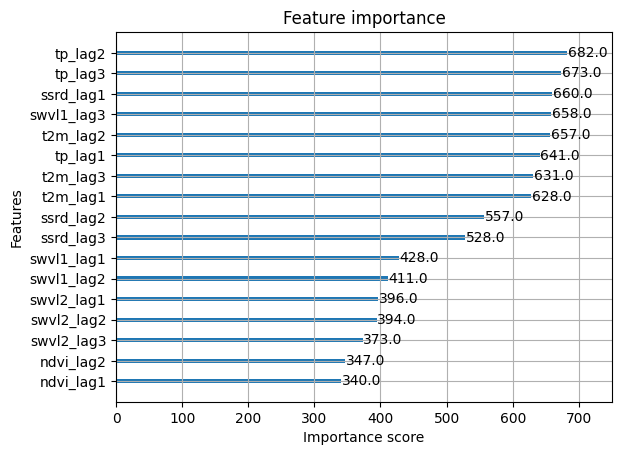

In [22]:
plot_importance(model)
plt.show()

In [23]:
pd.Series(y_pred_prob[y_valid == 1]).describe()

count    11.000000
mean      0.276208
std       0.393011
min       0.009403
25%       0.012439
50%       0.022354
75%       0.560085
max       0.980556
dtype: float64

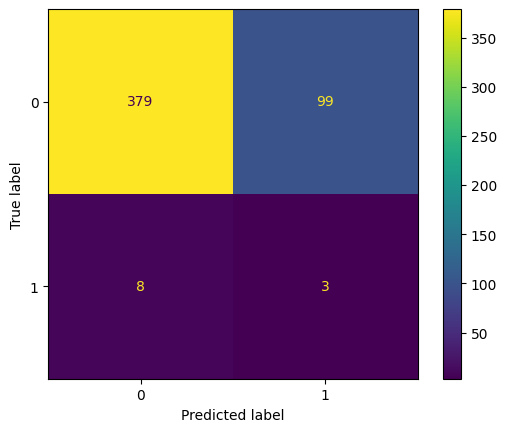

In [24]:
cm = confusion_matrix(y_valid, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()


# Save model to Model Registry

In [25]:
file_name = '../models/xgboost_model'
pickle.dump(model, open(file_name, "wb"))


In [26]:
project = hopsworks.login(api_key_value=os.getenv('HOPSWORKS_API_KEY'))
mr = project.get_model_registry()

2026-01-06 06:39:37,058 INFO: Initializing external client
2026-01-06 06:39:37,058 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-06 06:39:38,425 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286351


In [27]:
res_dict = { 
            "ROC": f"{roc:.2f}",
            "Avg Acc": f"{ap:.2f}",
            "False Pos": str(cm[0,1]),
            "False Neg": str(cm[1,0])
        }

beetle_model = mr.python.create_model(
        name='xgboost_model', 
        metrics=res_dict
    )

# Saving the model artifacts to the model registry
beetle_model.save('../models/')

Uploading /Users/jp/Documents/GitHub/scalable_ml/notebooks/../models//xgboost_model: 100.000%|██████████| 894473/894473 elapsed<00:05 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:12<00:00,  2.12s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286351/models/xgboost_model/3


Model(name: 'xgboost_model', version: 3)